In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filtered_uncropped_dir = '/content/drive/My Drive/GA/Capstone/capstone/images/CelticsImages/FilteredUncropped/'
filtered_cropped_dir = '/content/drive/My Drive/GA/Capstone/capstone/images/CelticsImages/FilteredCropped/'

In [4]:
def count_images(directory):
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len([file for file in files if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))])
    return total_images

In [5]:
total_uncropped_solo_images = count_images(os.path.join(filtered_uncropped_dir, 'Solo'))
total_uncropped_nonsolo_images = count_images(os.path.join(filtered_uncropped_dir, 'NonSolo'))

In [6]:
print(total_uncropped_solo_images)

330


In [7]:
total_uncropped_images = total_uncropped_solo_images + total_uncropped_nonsolo_images
total_uncropped_train_images = int(total_uncropped_images * 0.8)  # 80% for training
total_uncropped_val_images = int(total_uncropped_images * 0.2)

In [8]:
steps_per_epoch_uncropped = total_uncropped_train_images // 32
validation_steps_uncropped = total_uncropped_val_images // 32

print(f"Total uncropped training images: {total_uncropped_train_images}")
print(f"Total uncropped validation images: {total_uncropped_val_images}")
print(f"Steps per epoch for uncropped: {steps_per_epoch_uncropped}")
print(f"Validation steps for uncropped: {validation_steps_uncropped}")

Total uncropped training images: 534
Total uncropped validation images: 133
Steps per epoch for uncropped: 16
Validation steps for uncropped: 4


In [9]:
def custom_data_generator(directory, target_size, batch_size, class_mode, subset):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # 80/20 train/test split
    )

    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        subset=subset
    )

    while True:
        try:
            batch_x, batch_y = next(generator)
            yield batch_x, batch_y
        except Exception as e:
            print(f"Skipping a batch due to error: {e}")

In [10]:
train_generator = custom_data_generator(
    filtered_uncropped_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # binary classification
    subset='training'
)

In [11]:
validation_generator = custom_data_generator(
    filtered_uncropped_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # binary classification
    subset='validation'
)

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history_uncropped = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_uncropped,
    validation_data=validation_generator,
    validation_steps=validation_steps_uncropped,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Found 535 images belonging to 2 classes.
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5211 - loss: 0.7638 Found 133 images belonging to 2 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 269s 14s/step - accuracy: 0.5247 - loss: 0.7610 - val_accuracy: 0.6797 - val_loss: 0.5954
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8090 - loss: 0.4141 - val_accuracy: 0.7129 - val_loss: 0.5306
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9284 - loss: 0.2335 - val_accuracy: 0.8911 - val_loss: 0.3531
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9714 - loss: 0.1430 - val_accuracy: 0.9109 - val_loss: 0.3005
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9900 - loss: 0.0670 - val_accuracy: 0.8911 - val_loss: 0.3094
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9963 - loss: 0.0383 - val_accuracy: 0.8984 - val_loss: 0.2686
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 1.0000 - loss: 0.0230 - v

In [16]:
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [17]:
best_epoch_uncropped = history_uncropped.history['val_loss'].index(min(history_uncropped.history['val_loss']))

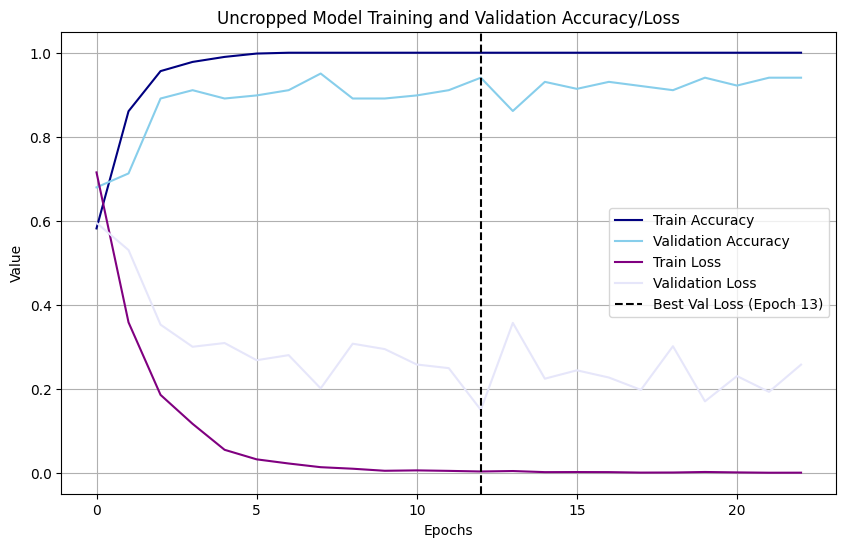

In [18]:
plt.figure(figsize=(10, 6))

# Plotting accuracy
plt.plot(history_uncropped.history['accuracy'], label='Train Accuracy', color='navy')
plt.plot(history_uncropped.history['val_accuracy'], label='Validation Accuracy', color='skyblue')

# Plotting loss
plt.plot(history_uncropped.history['loss'], label='Train Loss', color='purple')
plt.plot(history_uncropped.history['val_loss'], label='Validation Loss', color='lavender')

plt.axvline(x=best_epoch_uncropped, color='black', linestyle='--', label=f'Best Val Loss (Epoch {best_epoch_uncropped + 1})')
plt.title('Uncropped Model Training and Validation Accuracy/Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
models_dir = '/content/drive/My Drive/GA/Capstone/capstone/models/'

In [20]:
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [21]:
uncropped_model_path = os.path.join(models_dir, 'celtics_uncropped_model.h5')
model.save(uncropped_model_path)

print(f"Uncropped model saved to {uncropped_model_path}")

Uncropped model saved to /content/drive/My Drive/GA/Capstone/capstone/models/celtics_uncropped_model.h5


In [22]:
total_cropped_solo_images = count_images(os.path.join(filtered_cropped_dir, 'SoloLabeled'))
total_cropped_nonsolo_images = count_images(os.path.join(filtered_cropped_dir, 'NonSoloLabeled'))

In [23]:
total_cropped_images = total_cropped_solo_images + total_cropped_nonsolo_images
total_cropped_train_images = int(total_cropped_images * 0.8)  # 80% for training
total_cropped_val_images = int(total_cropped_images * 0.2)

In [24]:
steps_per_epoch_cropped = total_cropped_train_images // 32
validation_steps_cropped = total_cropped_val_images // 32

print(f"Total cropped training images: {total_cropped_train_images}")
print(f"Total cropped validation images: {total_cropped_val_images}")
print(f"Steps per epoch for cropped: {steps_per_epoch_cropped}")
print(f"Validation steps for cropped: {validation_steps_cropped}")

Total cropped training images: 512
Total cropped validation images: 128
Steps per epoch for cropped: 16
Validation steps for cropped: 4


In [25]:
train_generator_cropped = custom_data_generator(
    filtered_cropped_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # binary classification
    subset='training'
)

In [26]:
validation_generator_cropped = custom_data_generator(
    filtered_cropped_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # binary classification
    subset='validation'
)

In [27]:
for layer in base_model.layers[-4:]:  # fine-tuning only the top layers of the model
    layer.trainable = True

In [28]:
def lr_schedule(epoch):
    if epoch < 10:
        return 1e-5
    else:
        return 1e-6

In [29]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [30]:
model = Model(inputs=base_model.input, outputs=predictions)


In [31]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [32]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    LearningRateScheduler(lr_schedule)
]

In [33]:
# in this particular iteration of the model, I played around with the fine-tuning portion and
# it broke, so the model I used in my presentation was the first-pass model
# I had gotten the fine-tuning to run before, but I unlocked too many of the top layers
# and it made the model worse. This time, I lowered the learning rate from 1e-3 to 1e-5, and I
# only unlocked the top 4 layers. However, I must have done something wrong because the first epoch got
# stuck in an infinite loop (this had happened before because some of my images didn't work with
# Keras, so I must have done something wrong wrt the function that discards the bad images)
# However, I do want to note, that I had been able to re-train the top layers of MobileNetv2


history_finetune = model.fit(
    train_generator_cropped,
    validation_data=validation_generator_cropped,
    epochs=50,
    callbacks=callbacks
)

Found 512 images belonging to 2 classes.
Epoch 1/50
    908/Unknown 262s 245ms/step - accuracy: 0.9028 - loss: 0.2293

KeyboardInterrupt: 

In [ ]:
best_epoch_finetune = history_finetune.history['val_loss'].index(min(history_finetune.history['val_loss']))

plt.figure(figsize=(10, 6))

plt.plot(history_finetune.history['accuracy'], label='Train Accuracy', color='navy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', color='skyblue')

plt.plot(history_finetune.history['loss'], label='Train Loss', color='purple')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', color='lavender')

plt.axvline(x=best_epoch_finetune, color='black', linestyle='--', label=f'Best Val Loss (Epoch {best_epoch_finetune})')
plt.title('Fine-Tuned Model Training and Validation Accuracy/Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/content/drive/My Drive/GA/Capstone/capstone/models/fine_tuned_model.h5')